## Demo to use AI-driven Cloud Classification Atlas:AICCA 
Author: Takuya Kurihana  
About scientific background, please read our [paper](https://www.mdpi.com/2072-4292/14/22/5690). 

The AI-driven Cloud Classification Atlas delivers the information from multi-spectral satellite imagery from NASA MODIS Aqua and Terra instruments in a compact form (from 800TB to 50GB, excluding metadata), enables data-driven diagnosis of patterns of cloud organization, provides insight into cloud evolution on timescales of hours to decades, and helps democratize climate research
by facilitating access to core data.

This notebook gives an example of usage of AICCA dataset following the python functions and visualizations at a high-level.

Example datasets can be downloaded from a Globus endpoint (please download here: [Globus endpoint](https://app.globus.org/file-manager?origin_id=dc1bfe8a-cbc9-11ec-b95a-0f43df60473d&origin_path=%2F)). You need to register Globus, a high-speed data transfer service, to download AICCA dataset. 
Note that to facilliate the use of [AICCA Patch-Level data](https://www.mdpi.com/2072-4292/14/22/5690) in Python Pandas framework, we composite all patch labels, four physical variables (cloud optical thickness, cloud top pressure, cloud effective radius, and cloud liquid/ice phase), with **latitude and longitude values** that are provided by external MOD03/MYD03 products into CSV format.

---------
### Mount your drive if using on Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



### Import libraries

In [2]:
import os
import glob
import time
import datetime
import pandas as pd
import numpy as np

try:
  import netCDF4
except:
  ! pip install netCDF4

In [61]:
# visualizatino libraries below
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

try:
    import cartopy
    import cartopy as cart
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except:
    # https://stackoverflow.com/questions/60111684/geometry-must-be-a-point-or-linestring-error-using-cartopy
    ! pip uninstall -y shapely 
    ! pip install shapely --no-binary shapely
    ! pip install cartopy
    pass
  
try:
  import plotly.express as px
except:
  ! pip install plotly
  import plotly.express as px
  #import plotly.io as pio
  #pio.renderers.default = "notebook_connected"
  from plotly.offline import plot, iplot, init_notebook_mode
  import plotly.graph_objs as go
  init_notebook_mode(connected=True)
  pass

## Helper functions

In [4]:
def read_csv_per_day(year:int, sday:int, eday:int, basedir:str, usecols=None) -> pd.core.frame.DataFrame:
    """function to read data here for each day
    """
    # read both aqua and terra data
    csvlist = []
    for day in range(sday, eday+1,1):
      csvlist.extend(glob.glob(os.path.join( *[basedir, f"{year}" ,
                                            f"{year}_{str(day).zfill(3)}*.csv"]))
                    )
    if len(csvlist) == 0:
        return pd.DataFrame()
    df = pd.concat([ pd.read_csv(x, usecols=usecols) 
                    for x in csvlist], axis=0).reset_index().drop(labels=['index'], axis=1)
    
    # transform string timestamp to datetime object
    def convert_to_dt(x):
      return datetime.datetime.strptime(str(x)[:19], '%Y-%m-%d %H:%M:%S')
    try:
      df['Timestamp'] = df.Timestamp.apply(lambda x: convert_to_dt(x) )
    except:
      pass
    return df  

In [5]:
def new_grid_estimator_decimal(x, lat_array):
    ex = lat_array[np.argmin(np.abs(lat_array-x))]
    return ex

def new_grid_lon_helper(x, lon_array):
        x = lon_array[np.argmin(np.abs(lon_array-x))]
        if x == -180:
            x = 180
        return x

In [47]:
def calc_local_rfo_label_grid(df_all, nlats=180, nlons=360, south=-89.5, north=89.5, west=-179, east=180, 
                              degree=1, nclusters=42, variables=['Cloud_Fraction']) -> np.ndarray:
    """function to calculate relative frequency of occurrence per N degree x N degree grid cell
    """        
    # assume one lat/lon grid has one assignment
    cluster_array   =  np.zeros((nlats,nlons, nclusters))
    count_array  =  np.zeros((nlats,nlons))
    phys_array      =  np.zeros((nlats,nlons, nclusters, len(variables))).astype(np.float32)    
            
    # subset df per cluster
    lat_array = np.linspace(south, north, nlats)
    lon_array = np.linspace(west , east , nlons)
    
    # round for lat and lon at grid-cell
    df_all['lat'] = df_all['lat'].apply(lambda x: new_grid_estimator_decimal(x, lat_array) if not np.isnan(x) else np.nan)
    df_all['lon'] = df_all['lon'].apply(lambda x: new_grid_lon_helper(x, lon_array) if not np.isnan(x) else np.nan)
    
    # subset
    dfd = df_all.groupby(['lat', 'lon','Label']).size().reset_index(name='counts')  #denomi

    # select specific cluster
    pdf =  df_all.groupby(['lat', 'lon','Label']).mean()
    
    if len(dfd) > 1 and len(pdf) > 1:
      for (_, rS) , ((ilat, ilon, il), pS) in zip(dfd.iterrows(), pdf.iterrows()) : 
        #print(ilat, ilon, int(np.argwhere(lat_array == ilat)), np.argwhere(lon_array == ilon))
        lat_idx = int(np.argwhere(lat_array == ilat))
        lon_idx = int(np.argwhere(lon_array == ilon))
        cluster_array[lat_idx, lon_idx, il-1] = rS.counts # index 0 starts but label starts from 1
        for vdx, variable in enumerate(variables):
            phys_array[lat_idx, lon_idx, il-1, vdx] += pS[variable]
    
      count_array = np.nansum(cluster_array, axis=(-1))
    return cluster_array , phys_array, count_array 

### Plotting patch-label per day
Please change and specify `basedir` where you placed downloaded sample AICCA dataset.

In [12]:
df = read_csv_per_day(year=2021, sday=1, eday=1, basedir='/content/drive/My Drive/clouds/AICCA-csv-public')

In [13]:
df.columns

Index(['Label', 'Timestamp', 'Cloud_Optical_Thickness_mean',
       'Cloud_Optical_Thickness_std', 'Cloud_Phase_Infrared_clear-sky',
       'Cloud_Phase_Infrared_liquid', 'Cloud_Phase_Infrared_ice',
       'Cloud_Phase_Infrared_undef', 'Cloud_Top_Pressure_mean',
       'Cloud_Top_Pressure_std', 'Cloud_Effective_Radius_mean',
       'Cloud_Effective_Radius_std', 'lat', 'lon', 'platform', 'swath'],
      dtype='object')

In [ ]:
df

Label           Timestamp  Cloud_Optical_Thickness_mean  \
0         29 2021-01-01 00:45:00                      5.970236   
1         38 2021-01-01 00:45:00                     10.538337   
2         38 2021-01-01 00:45:00                      9.017957   
3         26 2021-01-01 00:45:00                     12.555588   
4         33 2021-01-01 00:45:00                     10.218677   
...      ...                 ...                           ...   
19422     13 2021-01-01 22:40:00                     23.842093   
19423     13 2021-01-01 22:40:00                     23.844763   
19424     16 2021-01-01 22:40:00                     13.369909   
19425     14 2021-01-01 22:40:00                      8.054954   
19426     14 2021-01-01 22:40:00                     10.854354   

       Cloud_Optical_Thickness_std  Cloud_Phase_Infrared_clear-sky  \
0                         8.277431                           10036   
1                         9.209682                            9785   
2                         7.471433                            9425   
3                        10.668962                             568   
4                         8.384299                             281   
...                            ...                             ...   
19422                    13.963388                             137   
19423                    14.205302                               0   
19424                     8.898944                             200   
19425                     4.557443                            3310   
19426                     8.860266                            3260   

       Cloud_Phase_Infrared_liquid  Cloud_Phase_Infrared_ice  \
0                             6348                         0   
1                             6595                         4   
2                             6950                         9   
3                            15192                       370   
4                            16103                         0   
...                            ...                       ...   
19422                        14032                      1364   
19423                        16149                        51   
19424                        13523                      2034   
19425                         6031                      6383   
19426                         4358                      7717   

       Cloud_Phase_Infrared_undef  Cloud_Top_Pressure_mean  \
0                               0                971.88330   
1                               0                935.20306   
2                               0                942.85890   
3                             254                882.07166   
4                               0                901.36560   
...                           ...                      ...   
19422                         851                662.51404   
19423                         184                692.39530   
19424                         627                849.70060   
19425                         660                855.02680   
19426                        1049                733.95610   

       Cloud_Top_Pressure_std  Cloud_Effective_Radius_mean  \
0                   44.941257                    21.232635   
1                   57.157010                    19.885970   
2                   48.381252                    16.349905   
3                  118.820030                    17.113518   
4                   40.659824                    15.468930   
...                       ...                          ...   
19422               69.873640                     8.444285   
19423               77.484985                    12.715726   
19424               83.578320                    12.577571   
19425              110.584150                    11.143586   
19426              181.251370                     8.315069   

       Cloud_Effective_Radius_std        lat         lon platform  swath  
0                        4.908980  24.7

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


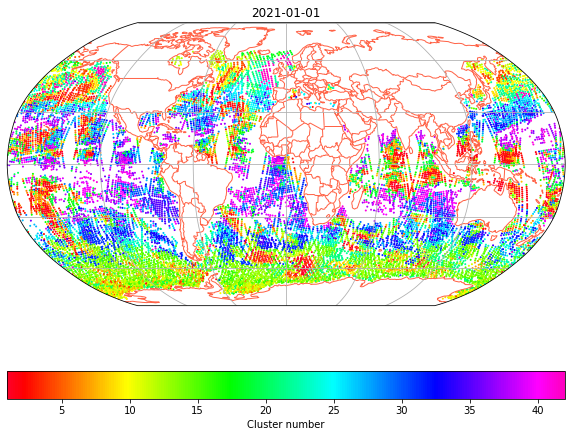

In [ ]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson())

ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

sc = plt.scatter(x=df.lon, y=df.lat,
            c=df.Label,
            cmap='gist_rainbow',
            s=1,
            transform=ccrs.PlateCarree()) ## Important
cbar = plt.colorbar(sc, orientation='horizontal')
cbar.ax.set_xlabel('Cluster number')
plt.title('2021-01-01')
plt.show()

### Calculate and Plot Relative Frequency of Occurence (RFO) per week

In [48]:
def main(year, sday, eday, aiccadir, usecols=None, nlats=180, nlons=360, variables=[]):
  """caluclate RFO from sday to eday. 
      Input
        aiccadir (str) : directory name where you downloaded our example aicca dataset

      Output
        rfo_array (np.nd.array) : array of rfo values ranging in [0,1]. you may want to multiply x 100 when plotting
        mphys_array (np.nd.array) : mean physical parameter values per grid per cluster

  """
  rfo_array = None
  mphys_array = None
  
  t1 = time.time()
  for day in range(sday, eday+1, 1):
    df = read_csv_per_day(year=year, sday=sday, eday=eday, 
                          basedir=aiccadir, usecols=usecols)
    
  # calculate rfo and mean physics values per grid
  _cluster_array , _phys_array, count_array = calc_local_rfo_label_grid(df, nlats, nlons, variables=variables) 

  # switch axis for computation
  _cluster_array = np.moveaxis(_cluster_array, -1, 0)
  _phys_array = np.moveaxis(_phys_array, -1, 0)
  if rfo_array is None  and mphys_array is None:
        rfo_array   =  np.expand_dims(
                      np.divide(_cluster_array, count_array, out=np.zeros_like(_cluster_array), where=count_array!=0), axis=-1)
        mphys_array =  np.expand_dims(_phys_array,axis=-1)

  t2 = time.time() - t1
  print(f"Processing time == {t2/60.00} min", flush=True)
  # axis roll
  rfo_array = np.moveaxis(rfo_array, 0, -2) # (nlats, nlons, nlabels, ntimes)
  mphys_array = np.moveaxis(mphys_array, 0, -2)
  return rfo_array, mphys_array

In [8]:
# variables: col name of dataframe to get mean per grid values
variables =  [
    'Cloud_Optical_Thickness_mean',
    'Cloud_Top_Pressure_mean',
]

In [49]:
rfo_array, mphys_array = main(2021, 1, 7, aiccadir='/content/drive/My Drive/clouds/AICCA-csv-public', nlats=180, nlons=360, variables=variables)

Processing time == 0.5251142740249634 min


In [50]:
rfo_array.shape, mphys_array.shape

((180, 360, 42, 1), (180, 360, 42, 2, 1))

#### Make a custom cmap
A custom colormap color used at Figure.9 in our [paper](https://www.mdpi.com/2072-4292/14/22/5690)

In [ ]:
def get_cmap(cmapname, nlevels):
    cmap = matplotlib.cm.get_cmap(cmapname, nlevels)    # PiYG

    colors = []
    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        colors.append(matplotlib.colors.rgb2hex(rgba))
    return colors

In [ ]:
# we used three default cmap in matplotlib
bupu = get_cmap('BuPu', nlevels=11)
ocean_r = get_cmap('ocean_r', nlevels=11)
cool = get_cmap('cool', nlevels=11)

In [ ]:
mycolor_list = ocean_r[:1]+ocean_r[3:4]+ocean_r[6:7]+[bupu[-2]]+cool[-2:-1]

In [ ]:
mycmap = LinearSegmentedColormap.from_list("mycmap",mycolor_list )

#### Plotting RFOs for individual cluster

In [14]:
lats = np.linspace(-89.5, 89.5, 180)
lons = np.linspace(-179, 180 , 360)
LONS, LATS = np.meshgrid(lons, lats)

In [ ]:
cluster_number = 35

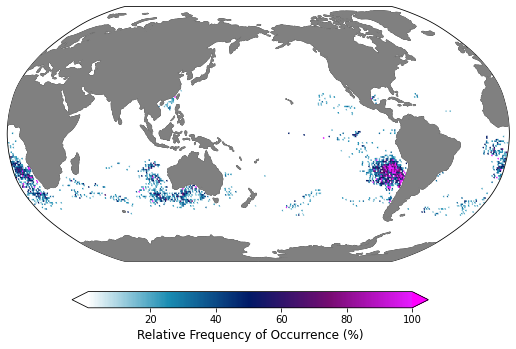

In [ ]:
cbar_axes=[0.225, 0.1, 0.55, 0.0375]


fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1, 1, projection=ccrs.Robinson(central_longitude=180.0))
  
mycmap.set_under(color='white')
mycmap.set_over(color='#ff00ff')

LONS, LATS = np.meshgrid(lons, lats)
CS = ax.scatter(LONS, LATS,c=rfo_array[:,:,cluster_number-1,0]*100,
            transform=ccrs.PlateCarree(),
            cmap=mycmap,
            s=1,
            vmin=1,vmax=100, rasterized=True)
ax.coastlines()
ax.add_feature(cart.feature.LAND, color='gray',zorder=100, edgecolor='k')
ax.set_global()
cax = plt.axes(cbar_axes)
cbar = fig.colorbar(CS,cax=cax,orientation = 'horizontal', extend='both') # linewidths; default = 1.5
cbar.ax.set_xlabel('Relative Frequency of Occurrence (%)', fontsize=12)
plt.show()

In [ ]:
cluster_number = 3

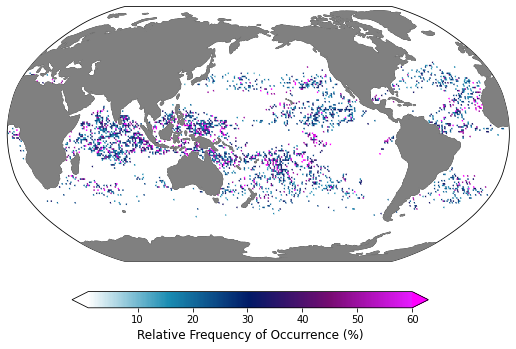

In [ ]:
cbar_axes=[0.225, 0.1, 0.55, 0.0375]


fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1, 1, projection=ccrs.Robinson(central_longitude=180.0))
  
mycmap.set_under(color='white')
mycmap.set_over(color='#ff00ff')

LONS, LATS = np.meshgrid(lons, lats)
CS = ax.scatter(LONS, LATS,c=rfo_array[:,:,cluster_number-1,0]*100,
            transform=ccrs.PlateCarree(),
            cmap=mycmap,
            s=1,
            vmin=1,vmax=60, rasterized=True)
ax.coastlines()
ax.add_feature(cart.feature.LAND, color='gray',zorder=100, edgecolor='k')
ax.set_global()
cax = plt.axes(cbar_axes)
cbar = fig.colorbar(CS,cax=cax,orientation = 'horizontal', extend='both') # linewidths; default = 1.5
cbar.ax.set_xlabel('Relative Frequency of Occurrence (%)', fontsize=12)
plt.show()

### Scroll different cluster patterns from class 1 to 42

In [51]:
# from numpy to dataframe
ny, nx, nc, _ = rfo_array.shape
lats_list = []
lons_list = []
rfos_list = []
labels_list = []
cots_list = []
ctps_list = []
for iy in range(ny):
  for ix in range(nx):
    for ic in range(42):
      r = float(rfo_array[iy, ix, ic])
      if r > 0:
        lats_list.append(lats[iy])
        lons_list.append(lons[ix])
        rfos_list.append(r*100.0) # [0,1] --> [0,100]
        labels_list.append(ic+1)
        cots_list.append(float(mphys_array[iy, ix, ic, 0]))
        ctps_list.append(float(mphys_array[iy, ix, ic, 1]))


sample_df = pd.DataFrame( np.concatenate(
    [ np.array(lats_list).reshape(-1,1), np.array(lons_list).reshape(-1,1), 
     np.array(labels_list).reshape(-1,1), np.array(rfos_list).reshape(-1,1),
     np.array(cots_list).reshape(-1,1), np.array(ctps_list).reshape(-1,1),
     ],axis=1
), columns=['Latitude', 'Longitude', 'Label', 'RFO']+variables )
sample_df['Label'] = sample_df['Label'].astype('int64', copy=False)

In [52]:
sample_df 

Latitude  Longitude  Label    RFO  Cloud_Optical_Thickness_mean  \
0          -83.5     -179.0      9   50.0                     11.541706   
1          -83.5     -179.0     10   50.0                     13.581081   
2          -82.5     -179.0      9   50.0                     14.091793   
3          -82.5     -179.0     10   50.0                     14.660854   
4          -82.5     -178.0      9   50.0                     10.271400   
...          ...        ...    ...    ...                           ...   
106586      67.5       -5.0     18  100.0                           NaN   
106587      67.5       -2.0     18  100.0                           NaN   
106588      67.5        2.0      5  100.0                           NaN   
106589      67.5        7.0     12  100.0                           NaN   
106590      67.5        9.0     18  100.0                           NaN   

        Cloud_Top_Pressure_mean  
0                    844.027954  
1                    618.830261  
2                    813.256714  
3                    830.404114  
4                    755.200867  
...                         ...  
106586               834.554993  
106587               918.714050  
106588               424.015198  
106589               655.737000  
106590               753.646667  

[106591 rows x 6 columns]

In [62]:
fig = px.scatter_mapbox(sample_df,
              lat="Latitude" ,
              lon="Longitude",
              hover_name="RFO",
              hover_data=variables,
              color="RFO",
              animation_frame='Label',
              mapbox_style='carto-positron',  
              category_orders={
                'Label':list(np.sort(sample_df['Label'].unique()))
              },                
              zoom=3)
fig.show()